# Supernova distances and redshifts (Part 1)

- First, explore fitting this data with the tecniques we have seen.
- Start from linear regression and polynomial regression
- For the case of polynomial regression, just fit many of them for now.
- Let's bet based on intuition! Which fit is the best?
- In what cases are you underfitting the data?
- In what cases are you overfitting the data?
- Now split the data into training and validation sets
- Implement a cross-validation procedure
- Pick the best!
- Does it agree with our bets?

In [1]:
import numpy as np
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

In [5]:
import sys
sys.path.append(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks")
from Utilities import plot_settings
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Raw Data')

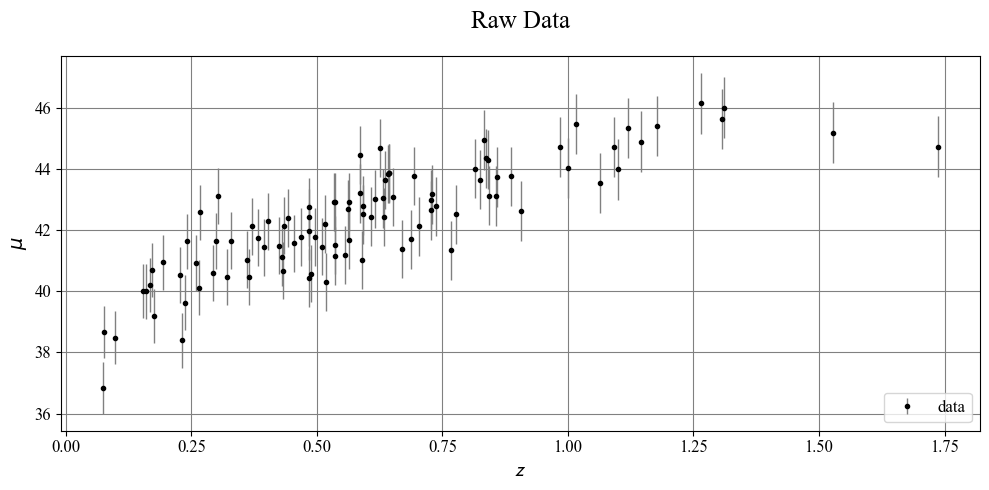

In [6]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel(r"$\mathcal{z}$")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.title('Raw Data')

In [7]:
import random
random_seed = 54

np.random.seed(random_seed)
random.seed(random_seed)

## Linear Regression

In [8]:
from sklearn.model_selection import train_test_split

In [14]:
z_train, z_test, mu_train, mu_test, dmu_train, dmu_test = train_test_split(z_sample, mu_sample, dmu, test_size=0.2, random_state=42)

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import chi2

In [48]:
lin_reg = LinearRegression()

Text(0.5, 1.0, 'Residuals')

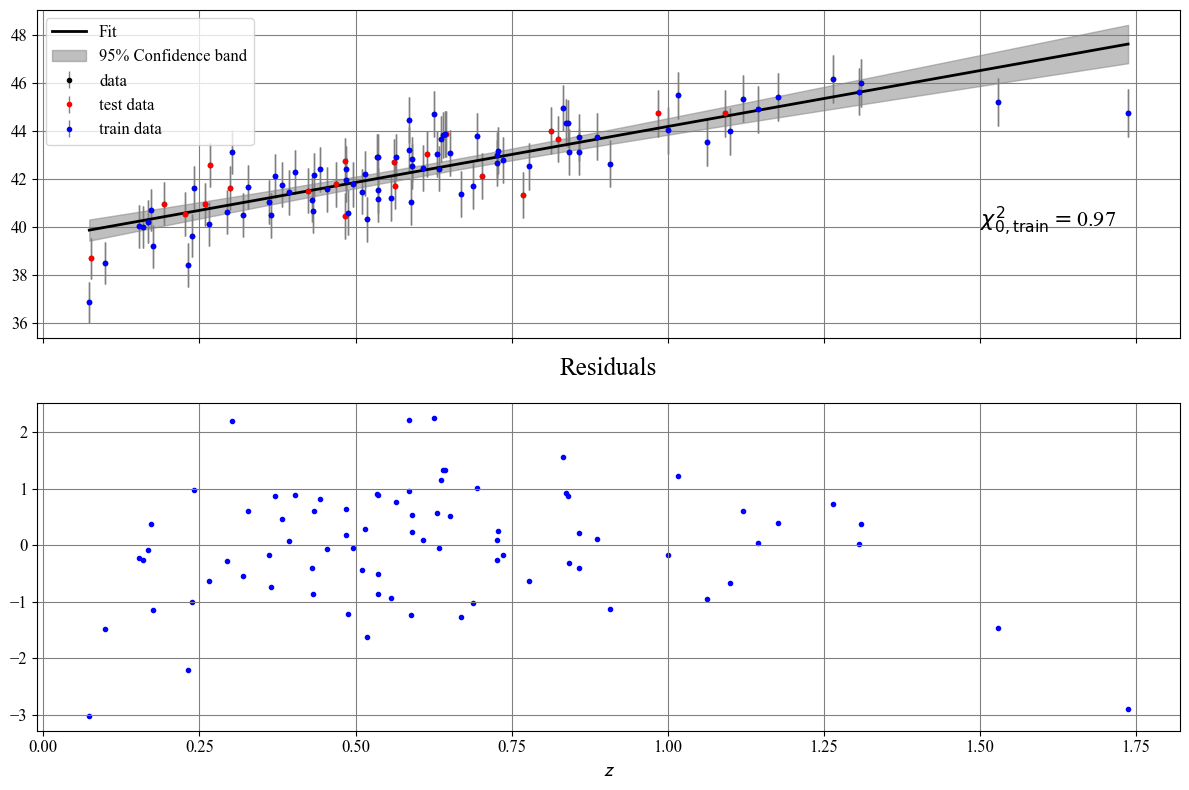

In [60]:
from scipy.stats import t

# Training data
X = z_train.reshape(-1, 1)
y = mu_train.reshape(-1, 1)
n = len(X)

# Fit model
lin_reg = LinearRegression()
lin_reg.fit(X, y)

# Predictions on training data
y_pred = lin_reg.predict(X)

# Residuals and residual variance
residuals = y - y_pred
s_err = np.sqrt(np.sum(residuals**2) / (n - 2))
s2 = np.sum(residuals**2) / (len(y) - 2)

# Compute chi-squared
chi2 = np.sum((y - y_pred)**2 / s2)

# Points to predict and plot confidence bands
x_fit = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_fit = lin_reg.predict(x_fit)

# Mean of X
x_mean = np.mean(X)

# Calculate standard error of the predictions
se_fit = s_err * np.sqrt(
    1/n + (x_fit - x_mean)**2 / np.sum((X - x_mean)**2)
)

# t-statistic for 95% confidence interval
t_val = t.ppf(0.975, df=n-2)  # two-sided 95%

# Upper and lower confidence bands
upper = y_fit.flatten() + t_val * se_fit.flatten()
lower = y_fit.flatten() - t_val * se_fit.flatten()

# Plot

fig, axs = plt.subplots(2,1, sharex=True, figsize=(12,8))
axs[0].errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
axs[0].errorbar(z_test, mu_test, dmu_test, fmt='.r', ecolor='gray', lw=1,label='test data')
axs[0].errorbar(z_train, mu_train, dmu_train, fmt='.b', ecolor='gray', lw=1,label='train data')
axs[0].plot(x_fit, y_fit, 'k-', label='Fit')
axs[0].fill_between(x_fit.flatten(), lower, upper, color='gray', alpha=0.5, label='95% Confidence band')
axs[0].text(
    1.5, 40, s=r"$\chi^{2}_{0, \text{train}}=$"+f"{chi2/(len(z_train - 2)):.2}",
    fontsize=16
)
axs[0].legend()

axs[1].set_xlabel(r"$\mathcal{z}$")
axs[1].scatter(z_train, residuals, marker='.', color='b')
axs[1].set_title('Residuals')

This fit shows high residuals in all the measured redshift spectrum.
## Polynomial Regression

In [62]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import root_mean_squared_error

Degree 2 → CV RMSE: 0.933
Degree 2 → Test RMSE: 0.954


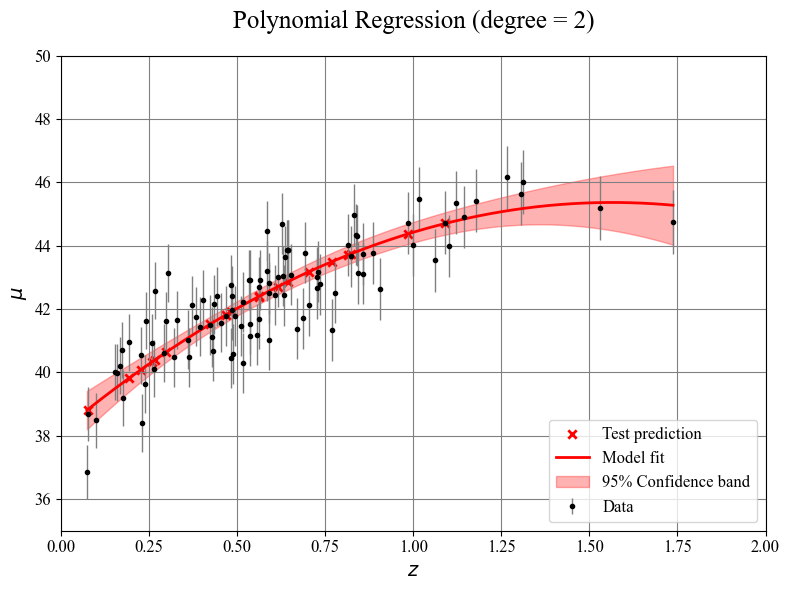

Degree 4 → CV RMSE: 0.997
Degree 4 → Test RMSE: 0.911


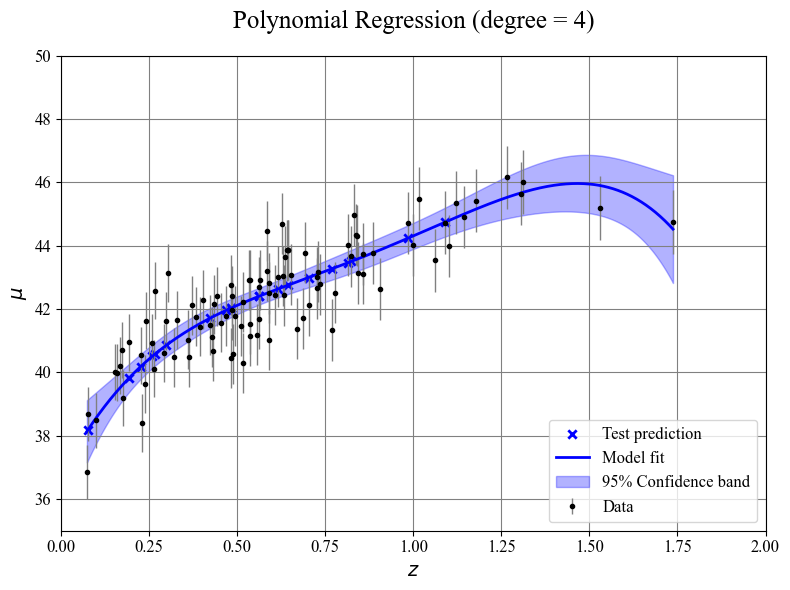

Degree 10 → CV RMSE: 40.941
Degree 10 → Test RMSE: 0.969


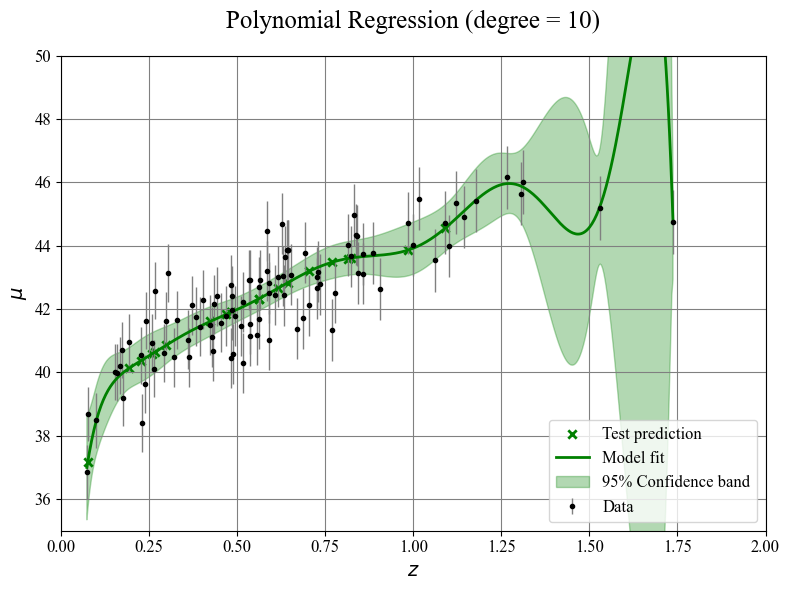

Degree 20 → CV RMSE: 4827816.817
Degree 20 → Test RMSE: 0.990


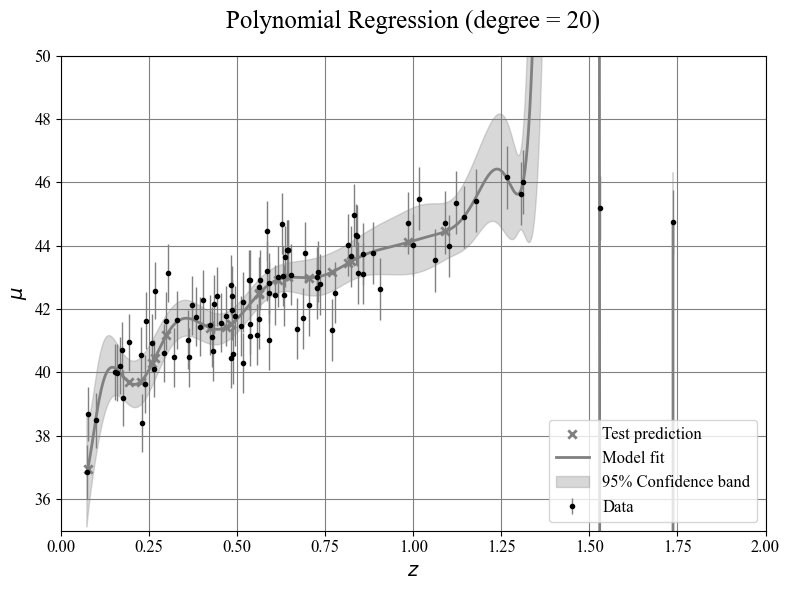

In [67]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

degrees = [2, 4, 10, 20]
colors = ['red', 'blue', 'green', 'gray']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

for deg, color in zip(degrees, colors):
    poly = PolynomialFeatures(degree=deg, include_bias=False)
    
    # Transform full training data once (for final fit)
    X_train_poly = poly.fit_transform(z_train.reshape(-1, 1))

    # --- KFold Cross-validation on training set ---
    cv_mses = []
    for train_idx, val_idx in kf.split(z_train):
        X_tr, X_val = z_train[train_idx], z_train[val_idx]
        y_tr, y_val = mu_train[train_idx], mu_train[val_idx]

        X_tr_poly = poly.fit_transform(X_tr.reshape(-1, 1))
        X_val_poly = poly.transform(X_val.reshape(-1, 1))

        model_cv = LinearRegression()
        model_cv.fit(X_tr_poly, y_tr)

        y_val_pred = model_cv.predict(X_val_poly)
        cv_mses.append(root_mean_squared_error(y_val, y_val_pred))
    cv_mse_mean = np.mean(cv_mses)
    print(f"Degree {deg} → CV RMSE: {cv_mse_mean:.3f}")

    # --- Fit on full training set ---
    model = LinearRegression()
    model.fit(X_train_poly, mu_train)

    X_test_poly = poly.transform(z_test.reshape(-1, 1))
    y_test_pred = model.predict(X_test_poly)

    test_mse = root_mean_squared_error(mu_test, y_test_pred)
    print(f"Degree {deg} → Test RMSE: {test_mse:.3f}")

    # --- Prepare smooth curve ---
    z_plot = np.linspace(min(z_sample), max(z_sample), 500).reshape(-1, 1)
    z_plot_poly = poly.transform(z_plot)
    mu_fit = model.predict(z_plot_poly)

    # --- Calculate residual variance ---
    y_train_pred = model.predict(X_train_poly)
    residuals = mu_train - y_train_pred
    n = len(mu_train)
    p = X_train_poly.shape[1]
    s_err = np.sqrt(np.sum(residuals**2) / (n - p - 1))  # degrees of freedom correction

    # --- Compute standard errors for confidence bands ---
    X_design = np.hstack([np.ones((n,1)), X_train_poly])  # add intercept
    X_plot_design = np.hstack([np.ones((z_plot_poly.shape[0],1)), z_plot_poly])
    cov_matrix = np.linalg.inv(X_design.T @ X_design)

    se_fit = np.array([
        np.sqrt(np.dot(x_row.T, np.dot(cov_matrix, x_row))) for x_row in X_plot_design
    ]) * s_err

    t_val = t.ppf(0.975, df=n - p - 1)

    upper = mu_fit.flatten() + t_val * se_fit
    lower = mu_fit.flatten() - t_val * se_fit

    # --- Plot ---
    plt.figure(figsize=(8, 6))
    plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Data')
    plt.scatter(z_test, y_test_pred, marker='x', color=color, label='Test prediction')
    plt.plot(z_plot, mu_fit, color=color, lw=2, label='Model fit')
    plt.fill_between(z_plot.flatten(), lower, upper, color=color, alpha=0.3, label='95% Confidence band')

    plt.xlabel(r"$z$")
    plt.ylabel(r"$\mu$")
    plt.title(f'Polynomial Regression (degree = {deg})')
    plt.legend(loc='lower right')
    plt.xlim(0, 2)
    plt.ylim(35, 50)
    plt.show()


Based on the four degrees I picked, the best fit is the $4^{th}$ degree polynomial; it is a good compromise between model complexity, degrees of freedom and how much the fit line intercepts data points.\
Using low degrees polynomials determines underfitting, meaing less of the data structure is grabbed from the fit line. On the other hand using too high degree polynomials determines overfitting, i.e. the model gets extremely good at training but its predictive power decreases.\
I can do better, cross validate on the number of degrees!

In [77]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, KFold

pipe = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('linear', LinearRegression())
])

param_grid = {'poly__degree': list(np.linspace(1,20,20,dtype=int))}

custom_cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Fit grid search on TRAIN data, NOT test data
grid = GridSearchCV(pipe, param_grid, cv=custom_cv, scoring='neg_mean_squared_error', return_train_score=True)
grid.fit(z_train.reshape(-1, 1), mu_train)

best_model = grid.best_estimator_
best_degree = grid.best_params_['poly__degree']

print(f"Best polynomial degree: {best_degree}")

# Evaluate on test set once after model selection
from sklearn.metrics import mean_squared_error
y_test_pred = best_model.predict(z_test.reshape(-1, 1))
test_mse = mean_squared_error(mu_test, y_test_pred)
print(f"Test MSE with best model (degree {best_degree}): {test_mse:.3f}")


Best polynomial degree: 2
Test MSE with best model (degree 2): 0.909


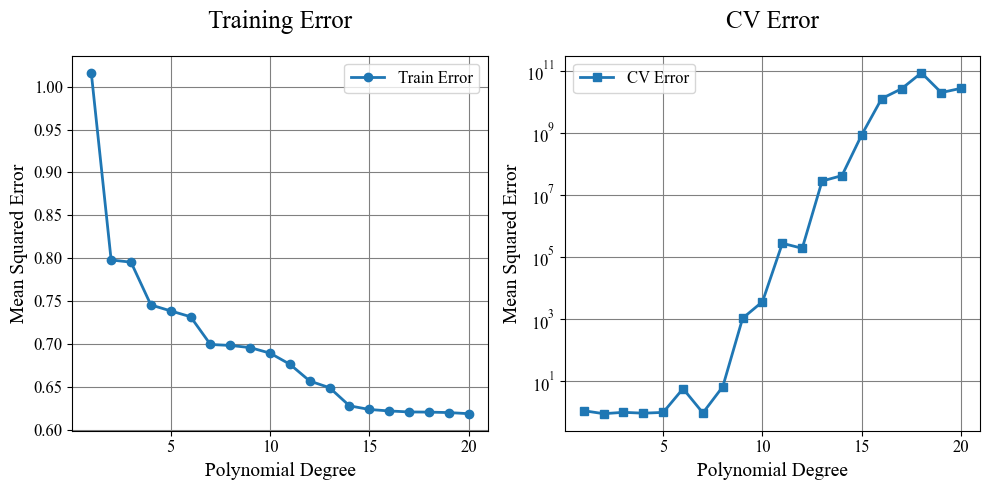

In [78]:
# Extract degrees, train and test scores
degrees = grid.cv_results_['param_poly__degree'].data.astype(int)
mean_train_scores = -grid.cv_results_['mean_train_score']  # Convert from negative MSE
mean_test_scores = -grid.cv_results_['mean_test_score']

# Plotting

fig, axs = plt.subplots(1,2)

axs[0].plot(degrees, mean_train_scores, label='Train Error', marker='o')
#plt.plot(degrees, mean_test_scores, label='CV Error', marker='s')
axs[0].set_xlabel('Polynomial Degree')
axs[0].set_ylabel('Mean Squared Error')
axs[0].set_title('Training Error')
axs[0].legend()

axs[1].plot(degrees, mean_test_scores, label='CV Error', marker='s')
axs[1].set_xlabel('Polynomial Degree')
axs[1].set_ylabel('Mean Squared Error')
axs[1].set_title('CV Error')
axs[1].legend()
axs[1].set_yscale('log')


As showed in the plots above, as the polynomial degree increases, the training MSE decreases since the number of parameters grows and thus it is easier for the model to best fit the data. At the same time CV MSE increases very rapidely! With a polynomial degree as low as 6 the model is greatly overfitting the data!

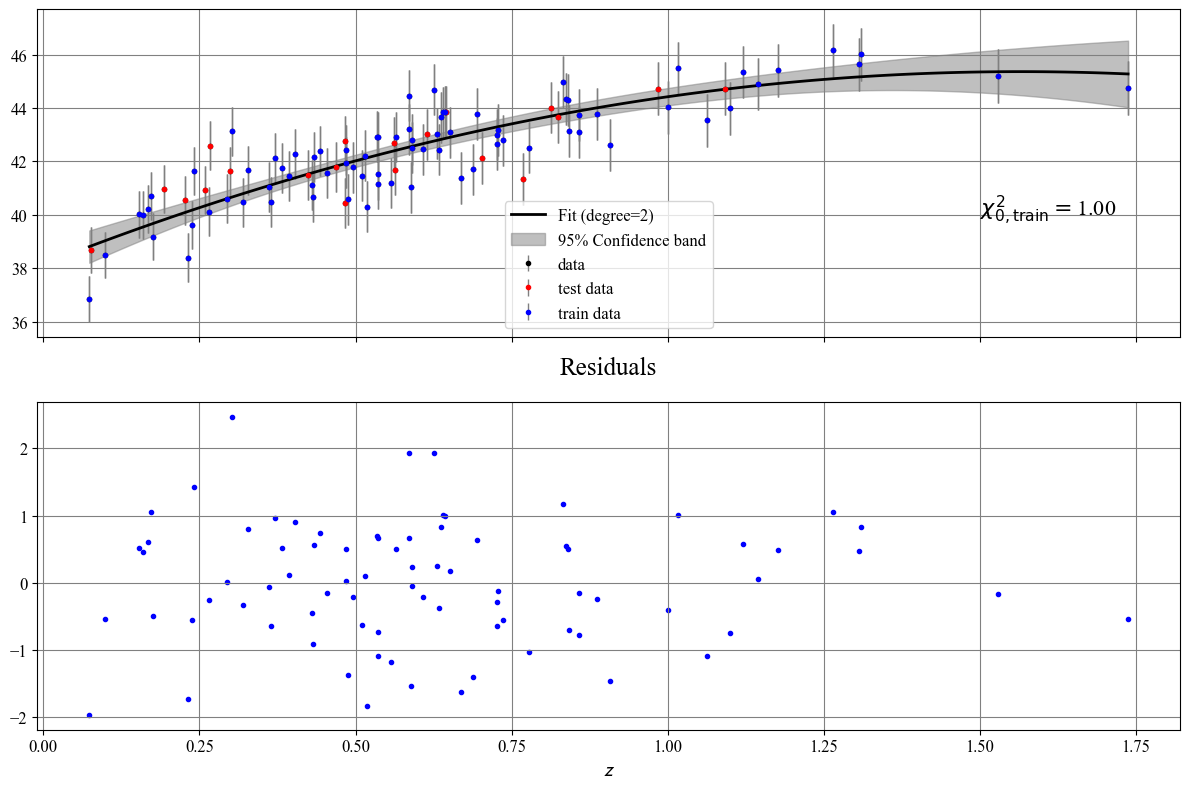

In [ ]:
model = best_model  # from your GridSearchCV, e.g. grid.best_estimator_

# Fit model on training data (optional if already fitted)
model.fit(X, y.ravel())  # make sure y is 1D for sklearn

# Predictions on training data
y_pred = model.predict(X).reshape(-1, 1)

# Residuals and residual variance
residuals = y - y_pred
p = model.named_steps['poly'].degree + 1  # number of params including intercept
s_err = np.sqrt(np.sum(residuals**2) / (n - p))
s2 = np.sum(residuals**2) / (n - p)

# Compute chi-squared
chi2 = np.sum((residuals**2) / s2)

# Points to predict and plot confidence bands
x_fit = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_fit = model.predict(x_fit).reshape(-1, 1)

# Mean of X transformed with polynomial features
poly = model.named_steps['poly']
X_poly = poly.transform(X)
x_fit_poly = poly.transform(x_fit)

# Add intercept term to design matrix
X_design = np.hstack([np.ones((n,1)), X_poly])
x_fit_design = np.hstack([np.ones((x_fit.shape[0],1)), x_fit_poly])

# Covariance matrix of parameters
cov_matrix = np.linalg.inv(X_design.T @ X_design)

# Calculate standard error of the predictions
se_fit = np.array([
    np.sqrt(np.dot(row.T, np.dot(cov_matrix, row))) for row in x_fit_design
]) * s_err

# t-statistic for 95% confidence interval
t_val = t.ppf(0.975, df=n - p)  # two-sided 95%

# Upper and lower confidence bands
upper = y_fit.flatten() + t_val * se_fit
lower = y_fit.flatten() - t_val * se_fit

# Plot
fig, axs = plt.subplots(2,1, sharex=True, figsize=(12,8))

axs[0].errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
axs[0].errorbar(z_test, mu_test, dmu_test, fmt='.r', ecolor='gray', lw=1, label='test data')
axs[0].errorbar(z_train, mu_train, dmu_train, fmt='.b', ecolor='gray', lw=1, label='train data')
axs[0].plot(x_fit, y_fit, 'k-', label=f'Fit (degree={model.named_steps["poly"].degree})')
axs[0].fill_between(x_fit.flatten(), lower, upper, color='gray', alpha=0.5, label='95% Confidence band')
axs[0].text(
    1.5, 40,
    s=r"$\chi^{2}_{0, \text{train}}=$" + f"{chi2/(n - p):.2f}",
    fontsize=16
)
axs[0].legend()

axs[1].scatter(z_train, residuals, marker='.', color='b')
axs[1].set_title('Residuals')
axs[1].set_xlabel(r"$\mathcal{z}$")

plt.show()


Let's see what happens adding new z points

In [84]:
new_z_sample, new_mu_sample, new_dmu = generate_mu_z(1000, random_state=1234)

In [85]:
idxs = np.random.choice(np.linspace(0,len(new_z_sample),len(new_z_sample), dtype=int)[new_z_sample > max(z_sample)], 20)

In [86]:
add_z_sample = new_z_sample[idxs]
add_mu_sample = new_mu_sample[idxs]

In [89]:
import numpy as np

# Assume best_model is fitted pipeline with 'poly' and 'linear' steps
poly = best_model.named_steps['poly']

# Prepare z_plot for smooth curve
z_plot = np.linspace(min(z_sample), max(z_sample), 500).reshape(-1, 1)

# Transform with polynomial features
X_plot_poly = poly.transform(z_plot)
X_train_poly = poly.transform(z_train.reshape(-1, 1))

# Add intercept (column of ones) to design matrices
X_train_design = np.hstack([np.ones((X_train_poly.shape[0], 1)), X_train_poly])
X_plot_design = np.hstack([np.ones((X_plot_poly.shape[0], 1)), X_plot_poly])

# Predict mean on plot points
mu_fit = best_model.predict(z_plot)

# Residuals on training set
y_train_pred = best_model.predict(z_train.reshape(-1, 1))
residuals = mu_train - y_train_pred

# Degrees of freedom = n - p (p includes intercept)
n = X_train_design.shape[0]
p = X_train_design.shape[1]
dof = n - p

# Mean squared error of residuals
mse = np.sum(residuals**2) / dof

# Covariance matrix of parameters
XtX_inv = np.linalg.inv(X_train_design.T @ X_train_design)
cov_matrix = mse * XtX_inv

# Prediction variance: diag(X_plot * Cov * X_plot.T)
pred_var = np.sum(X_plot_design @ cov_matrix * X_plot_design, axis=1)
pred_std = np.sqrt(pred_var)

# 1 sigma confidence bands
mu_upper = mu_fit + pred_std
mu_lower = mu_fit - pred_std


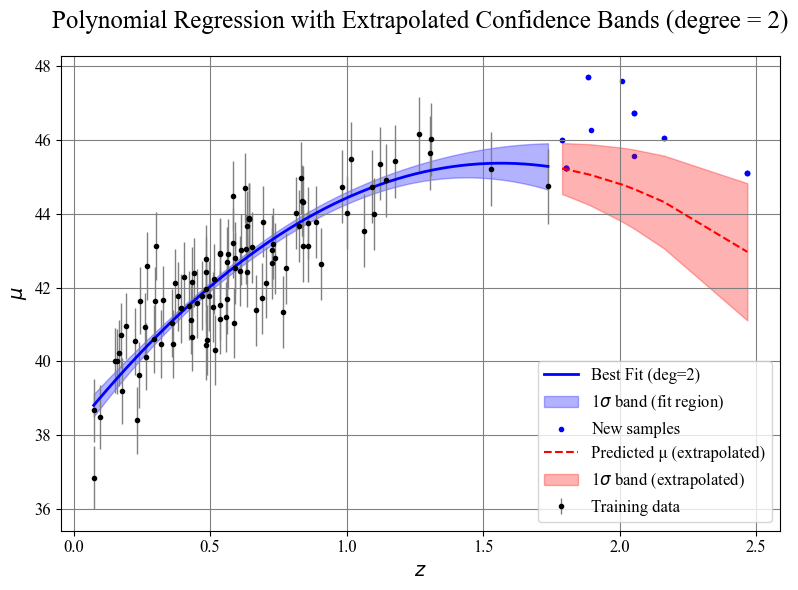

In [91]:
# Transform add_z_sample
add_X_poly = poly.transform(add_z_sample.reshape(-1, 1))

# Add intercept to design matrices
add_X_design = np.hstack([np.ones((add_X_poly.shape[0], 1)), add_X_poly])
X_train_design = np.hstack([np.ones((X_train_poly.shape[0], 1)), X_train_poly])

# Predictions on add_z_sample
add_mu_fit = model.predict(add_z_sample.reshape(-1, 1))

# Residuals on training set
residuals = y_train - model.predict(z_train.reshape(-1, 1))

# Degrees of freedom (n - p)
n = X_train_design.shape[0]
p = X_train_design.shape[1]
dof = n - p

# Mean squared error
mse = np.sum(residuals**2) / dof

# Covariance matrix with intercept
XtX_inv = np.linalg.inv(X_train_design.T @ X_train_design)
cov_matrix = mse * XtX_inv

# Compute prediction variance on add_z_sample (with intercept)
add_pred_var = np.sum(add_X_design @ cov_matrix * add_X_design, axis=1)
add_pred_std = np.sqrt(add_pred_var)

# Sort add_z_sample for plotting
sorted_idx = np.argsort(add_z_sample)
add_z_sorted = add_z_sample[sorted_idx]
add_mu_sorted = add_mu_fit[sorted_idx]
add_std_sorted = add_pred_std[sorted_idx]

add_mu_upper = add_mu_sorted + add_std_sorted
add_mu_lower = add_mu_sorted - add_std_sorted

# 1σ confidence bands on training fit region (already computed)
# mu_upper and mu_lower should be computed similarly with intercept included

# --- Plot ---
plt.figure(figsize=(8, 6))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Training data')
plt.plot(z_plot, mu_fit, color='blue', lw=2, label=f'Best Fit (deg={best_degree})')
plt.fill_between(z_plot.ravel(), mu_lower, mu_upper, color='blue', alpha=0.3, label=r'1$\sigma$ band (fit region)')

plt.scatter(add_z_sample, add_mu_sample, marker='.', color='blue', label='New samples')
plt.plot(add_z_sorted, add_mu_sorted, 'r--', lw=1.5, label='Predicted μ (extrapolated)')
plt.fill_between(add_z_sorted, add_mu_lower, add_mu_upper, color='red', alpha=0.3, label=r'1$\sigma$ band (extrapolated)')

plt.xlabel(r"$z$")
plt.ylabel(r"$\mu$")
plt.title(f'Polynomial Regression with Extrapolated Confidence Bands (degree = {best_degree})')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


This would not go well...

## Basis Function Regression (Gaussians)

In [92]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianBasis(BaseEstimator, TransformerMixin):
    def __init__(self, n_centers=10, sigma=1.0):
        self.n_centers = n_centers
        self.sigma = sigma

    def fit(self, X, y=None):
        X = X.reshape(-1, 1)
        self.centers_ = np.linspace(X.min(), X.max(), self.n_centers).reshape(-1, 1)
        return self

    def transform(self, X):
        X = X.reshape(-1, 1)
        return np.exp(-((X - self.centers_.T) ** 2) / (2 * self.sigma ** 2))

# Create pipeline
pipe = Pipeline([
    ('gauss', GaussianBasis()),  # Your custom Gaussian transformer
    ('linreg', LinearRegression())
])

# Define parameter grid
param_grid = {
    'gauss__n_centers': list(np.linspace(1,20,20, dtype=int)),
    'gauss__sigma': list(np.power(10,np.linspace(-3,3,7)))
}

# Grid search with CV
grid = GridSearchCV(pipe, param_grid, cv=custom_cv, scoring='neg_mean_squared_error')
grid.fit(x_train.reshape(-1, 1), y_train)

# Best model and parameters
best_model = grid.best_estimator_
best_params = grid.best_params_
print(f"Best Gaussian basis parameters: {best_params} | Best score")


Best Gaussian basis parameters: {'gauss__n_centers': np.int64(2), 'gauss__sigma': np.float64(10.0)} | Best score


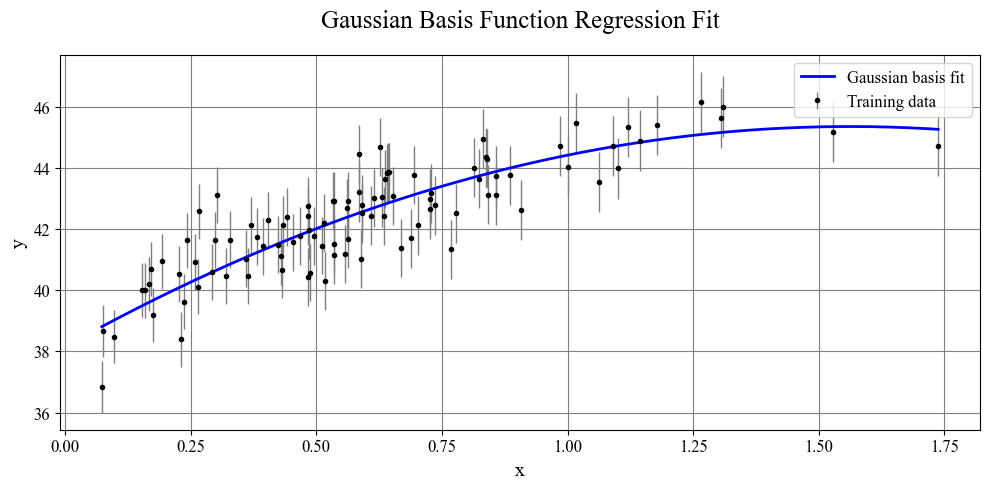

In [93]:
# Predict on a smooth range for plotting
x_plot = np.linspace(x_train.min(), x_train.max(), 500).reshape(-1, 1)
y_plot = best_model.predict(x_plot)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Training data')
plt.plot(x_plot, y_plot, color='blue', label='Gaussian basis fit')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Gaussian Basis Function Regression Fit')
plt.legend()
plt.grid(True)
plt.show()


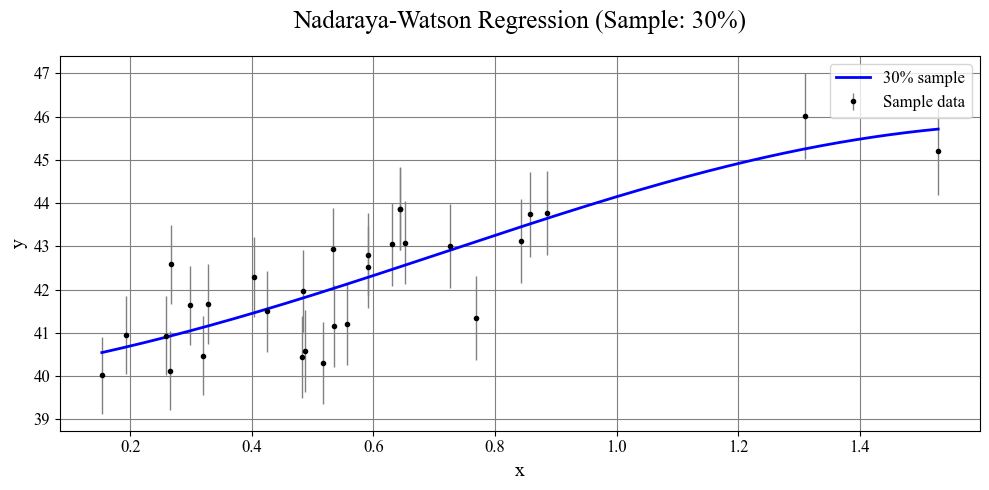

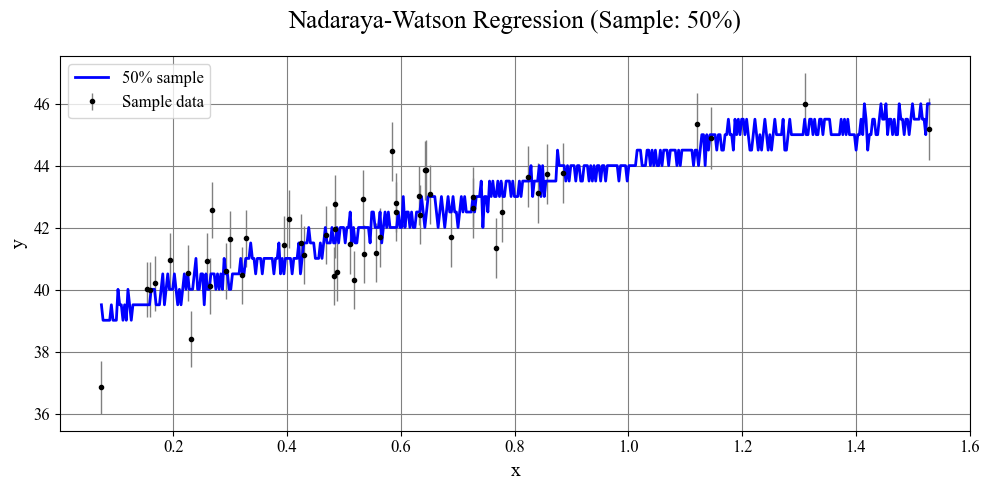

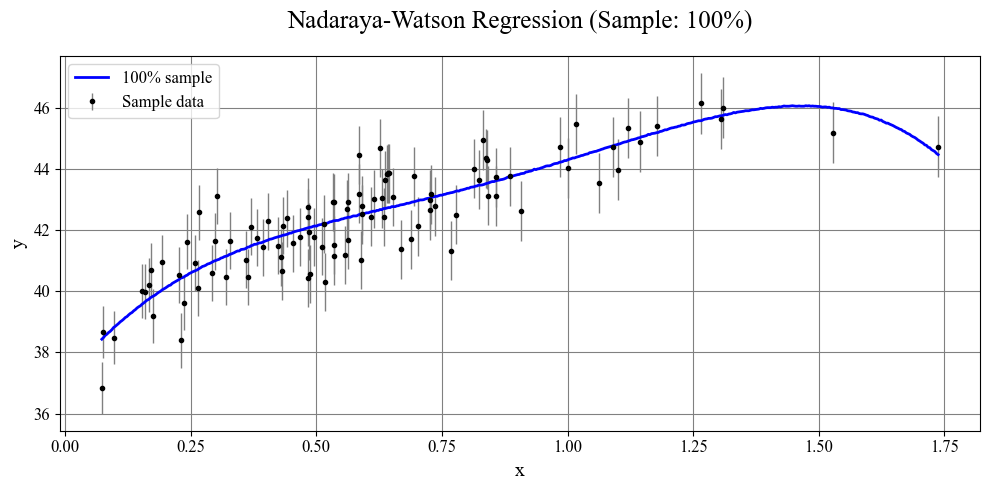

In [94]:
percs = [0.3, 0.5, 1.0]
random_seed = 54

np.random.seed(random_seed)
random.seed(random_seed)

# Calcolo una sola volta gli indici, con il massimo numero richiesto
N_max = int(max(percs) * z_sample.size)
all_idxs = np.random.choice(z_sample.size, N_max, replace=False)

for p in percs:
    N = int(p * z_sample.size)
    idxs = all_idxs[:N]  # prendi solo i primi N indici

    new_z = z_sample[idxs]
    new_mu = mu_sample[idxs]
    new_dmu = dmu[idxs]

    # Grid search over NW regressor
    grid = GridSearchCV(pipe, param_grid, cv=custom_cv, scoring='neg_mean_squared_error')
    grid.fit(new_z.reshape(-1, 1), new_mu)

    best_model = grid.best_estimator_

    # Predict for smooth curve
    x_plot = np.linspace(new_z.min(), new_z.max(), 500).reshape(-1, 1)
    y_plot = best_model.predict(x_plot)

    plt.errorbar(new_z, new_mu, new_dmu, fmt='.k', ecolor='gray', lw=1, label='Sample data')
    plt.plot(x_plot, y_plot, color='blue', label=f'{int(p*100)}% sample')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Nadaraya-Watson Regression (Sample: {int(p*100)}%)')
    plt.legend()
    plt.show()


## Kernel regression (Nadaraya-Watson)

In [95]:
from sklearn.base import RegressorMixin

In [96]:
class NadarayaWatson(BaseEstimator, RegressorMixin):
    def __init__(self, bandwidth=1.0):
        self.bandwidth = bandwidth

    def fit(self, X, y):
        self.X_train_ = X.reshape(-1, 1)
        self.y_train_ = y
        return self

    def predict(self, X):
        X = X.reshape(-1, 1)
        K = self._gaussian_kernel(X, self.X_train_)
        weights = K / K.sum(axis=1, keepdims=True)
        return weights.dot(self.y_train_)

    def _gaussian_kernel(self, X, X_train):
        # Pairwise squared Euclidean distances
        dists = (X - X_train.T)**2
        return np.exp(-dists / (2 * self.bandwidth ** 2))

In [97]:
# Define the bandwidth values to try
param_grid = {'bandwidth': list(np.power(10, np.linspace(-2,1,20)))}

# Perform 5-fold cross-validation
grid = GridSearchCV(NadarayaWatson(), param_grid, cv=custom_cv, scoring='neg_mean_squared_error')

# Fit on training data
grid.fit(x_train.reshape(-1, 1), y_train)

# Best model and bandwidth
best_model = grid.best_estimator_
best_bandwidth = grid.best_params_['bandwidth']
print("Best bandwidth:", best_bandwidth)


Best bandwidth: 0.04281332398719394


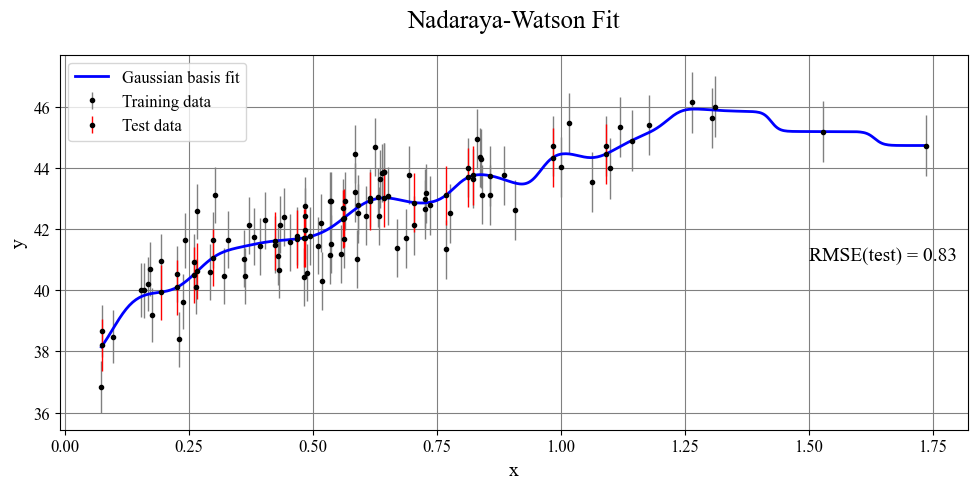

In [98]:
# Predict on a smooth range for plotting
x_plot = np.linspace(x_train.min(), x_train.max(), 500).reshape(-1, 1)
y_plot = best_model.predict(x_plot)
y_pred = best_model.predict(x_test.reshape(-1,1))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Training data')
plt.plot(x_plot, y_plot, color='blue', label='Gaussian basis fit')
plt.errorbar(x_test, y_pred, dmu_test, fmt='.k', ecolor='red', lw=1, label='Test data')
mse = root_mean_squared_error(y_test, y_pred)
plt.text(
    1.5, 41,s=f'RMSE(test) = {mse:.2}', fontsize=14
)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Nadaraya-Watson Fit')
plt.legend()
plt.grid(True)
plt.show()

Implementing Uber Loss Function

In [99]:
from sklearn.metrics import make_scorer
from sklearn.base import BaseEstimator, RegressorMixin

In [100]:
class NadarayaWatson(BaseEstimator, RegressorMixin):
    def __init__(self, bandwidth=1.0, epsilon=1e-6):
        self.bandwidth = bandwidth
        self.epsilon = epsilon

    def fit(self, X, y):
        self.X_ = np.asarray(X).reshape(-1, 1)
        self.y_ = np.asarray(y)
        return self

    def predict(self, X):
        X = np.asarray(X).reshape(-1, 1)
        weights = np.exp(-((X - self.X_.T) ** 2) / (2 * self.bandwidth ** 2))
        weights_sum = weights.sum(axis=1, keepdims=True)
        weights /= weights_sum
        return np.dot(weights, self.y_)

    def score(self, X, y):
        y_pred = self.predict(X)
        # Negative Uber loss (since GridSearchCV maximizes score)
        return -np.mean(np.sqrt((y - y_pred) ** 2 + self.epsilon))

In [101]:
param_grid = {
    'bandwidth': np.power(10, np.linspace(-2, 1, 10)),
    'epsilon': [1e-8, 1e-6, 1e-4, 1e-2]
}

grid = GridSearchCV(NadarayaWatson(), param_grid, cv=custom_cv)
grid.fit(x_train.reshape(-1, 1), y_train)

print("Best bandwidth:", grid.best_params_['bandwidth'])
print("Best epsilon:", grid.best_params_['epsilon'])

Best bandwidth: 0.046415888336127774
Best epsilon: 1e-08


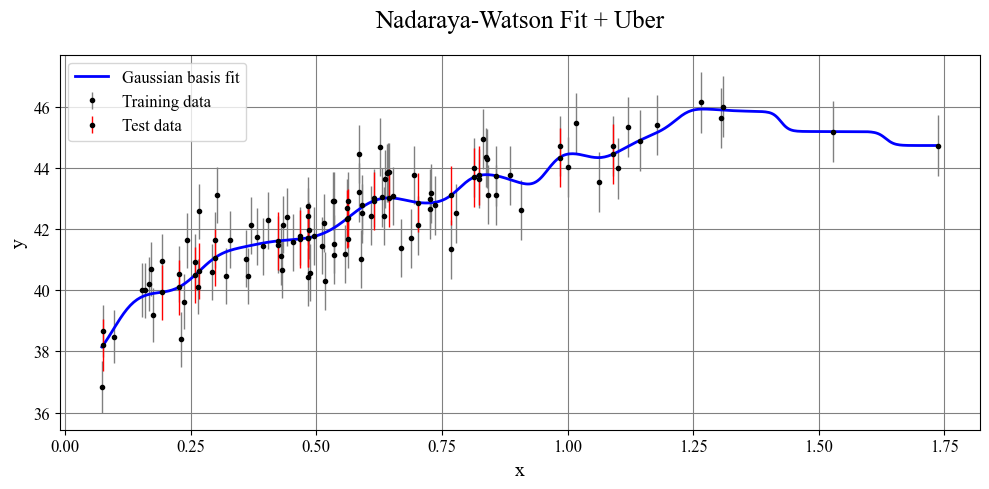

In [102]:
# Predict on a smooth range for plotting
x_plot = np.linspace(x_train.min(), x_train.max(), 500).reshape(-1, 1)
y_plot = best_model.predict(x_plot)
y_pred = best_model.predict(x_test.reshape(-1,1))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Training data')
gbf = plt.plot(x_plot, y_plot, color='blue', label='Gaussian basis fit')
plt.errorbar(x_test, y_pred, dmu_test, fmt='.k', ecolor='red', lw=1, label='Test data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Nadaraya-Watson Fit + Uber')
plt.legend()
plt.grid(True)
plt.show()

## Part 2

- The key ingredient in getting a good GPR fit is the choice of the kernel and its parameters.
- Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- But check out what's available in the kernels submodule of sklearn.gaussian_process
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

In [103]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, RationalQuadratic
from sklearn.preprocessing import StandardScaler

In [104]:
Kernels = []

In [105]:
def do_GPR_reg(kern, scaler, X_scaled, plot_scaled=False, plot_scaled_back=False):
    GPR = GaussianProcessRegressor(kernel=kern, n_restarts_optimizer=10)
    GPR.fit(X_scaled.T[0].reshape(-1,1), X_scaled.T[1].reshape(-1,1))
    
    if plot_scaled:
        # Predict on a smooth range for plotting
        x_plot = np.linspace(X_scaled.T[0].min(), X_scaled.T[0].max(), 500)
        y_plot, std = GPR.predict(x_plot.reshape(-1, 1), return_std=True)
        
        plt.scatter(X_scaled.T[0], X_scaled.T[1], marker='.', color='gray',label='Training data')
        plt.plot(x_plot, y_plot, color='blue', label='GPR fit')
        plt.fill_between(x_plot, y_plot-std, y_plot+std, color='blue', alpha=0.5, label=r'$1-\sigma$')
        plt.fill_between(x_plot, y_plot-2*std, y_plot+2*std, color='blue', alpha=0.2, label=r'$2-\sigma$')
        plt.xlabel(r'Scaled $z$')
        plt.ylabel(r'Scaled $\mu$')
        plt.title('Gaussian Process Regression (Scaled data))')
        plt.legend()
        plt.show()
        
    if plot_scaled_back:
        # Generate x values for plotting
        x_plot = np.linspace(X_scaled.T[0].min(), X_scaled.T[0].max(), 500).reshape(-1, 1)

        # Predict mean and std from GPR
        y_pred_scaled, y_std_scaled = GPR.predict(x_plot, return_std=True)

        # Stack mean prediction to shape (500, 2) for inverse transform
        temp_mean = np.hstack([x_plot, y_pred_scaled.reshape(-1, 1)])
        Y_pred = scaler.inverse_transform(temp_mean)

        # Create upper and lower bounds for inverse transform (mean ± std)
        temp_upper = np.hstack([x_plot, (y_pred_scaled + y_std_scaled).reshape(-1, 1)])
        temp_lower = np.hstack([x_plot, (y_pred_scaled - y_std_scaled).reshape(-1, 1)])

        temp_upper_2s = np.hstack([x_plot, (y_pred_scaled + 2*y_std_scaled).reshape(-1, 1)])
        temp_lower_2s = np.hstack([x_plot, (y_pred_scaled - 2*y_std_scaled).reshape(-1, 1)])

        Y_upper = scaler.inverse_transform(temp_upper)
        Y_lower = scaler.inverse_transform(temp_lower)

        Y_upper_2s = scaler.inverse_transform(temp_upper_2s)
        Y_lower_2s = scaler.inverse_transform(temp_lower_2s)

        # Extract the values
        z_scaled_back_fit = Y_pred.T[0]
        mu_scaled_back_fit = Y_pred.T[1]


        # Also get the training data back to original scale
        Y = scaler.inverse_transform(np.vstack([X_scaled.T[0], X_scaled.T[1]]).T)


        # Plot everything
        plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Training data')
        plt.plot(z_scaled_back_fit, mu_scaled_back_fit, color='blue', label='GPR fit')
        plt.fill_between(z_scaled_back_fit, Y_lower.T[1], Y_upper.T[1], color='blue', alpha=0.5, label=r"$1-\sigma$")
        plt.fill_between(z_scaled_back_fit, Y_lower_2s.T[1], Y_upper_2s.T[1], color='blue', alpha=0.2, label=r"$2-\sigma$")
        plt.xlabel(r'$z$')
        plt.ylabel(r'$\mu$')
        plt.title('GPR fit - '+str(kern))
        plt.legend()
        plt.grid(True)
        plt.show()

def select_best_kernel(X, y, kernels, custom_cross_validator, scoring='neg_mean_squared_error', n_restarts_optimizer=10):
    """
    Cross-validate multiple kernels with hyperparameter optimization in each fold.

    Parameters:
    -----------
    X : array-like, shape (n_samples,)
        Input features (1D).
    y : array-like, shape (n_samples,)
        Target values.
    kernels : list of sklearn.gaussian_process.kernels.Kernel
        List of kernel objects to evaluate.
    cv : int, default=5
        Number of cross-validation folds.
    scoring : str, default='neg_mean_squared_error'
        Scoring metric used by cross_val_score.
    n_restarts_optimizer : int, default=10
        Number of restarts for kernel hyperparameter optimizer during fitting.

    Returns:
    --------
    best_kernel : sklearn.gaussian_process.kernels.Kernel
        The kernel with the best average CV score.
    scores_dict : dict
        Dictionary mapping kernel string repr to average CV score.
    """

    best_kernel = None
    best_score = -np.inf
    scores_dict = {}

    for kern in kernels:
        gpr = GaussianProcessRegressor(kernel=kern, n_restarts_optimizer=n_restarts_optimizer)
        
        scores = cross_val_score(
            gpr,
            X.reshape(-1, 1),
            y,
            cv=custom_cross_validator,
            scoring=scoring,
            n_jobs=-1
        )
        mean_score = np.mean(scores)
        scores_dict[str(kern)] = mean_score
        print(f"Kernel: {kern}\n Mean CV Score: {mean_score:.5f}\n")

        if mean_score > best_score:
            best_score = mean_score
            best_kernel = kern

    print(f"Best kernel selected: {best_kernel}\nwith CV score: {best_score:.5f}")
    return best_kernel, scores_dict

In [106]:
X = np.vstack([z_sample, mu_sample]).T

In [107]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [108]:
Base_Kernels = [RBF(length_scale=0.001, length_scale_bounds=(1e-8, 1e8)) + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-10, 1e+1)),
           Matern(length_scale=0.001, length_scale_bounds=(1e-8, 1e8)) + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-10, 1e+1)),
           RationalQuadratic(length_scale=0.001) + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-10, 1e+1))]

In [109]:
# Define the regressor
gpr = GaussianProcessRegressor(kernel=Base_Kernels[0], n_restarts_optimizer=0)

# Define the param grid
param_grid = {
    'kernel__k1__length_scale': np.logspace(-3, -1, 10),
    'kernel__k2__noise_level': np.logspace(-1, 2, 5)
}

# Perform grid search
grid = GridSearchCV(gpr, param_grid, cv=custom_cv, scoring='neg_mean_squared_error')
grid.fit(x_train.reshape(-1, 1), y_train)

c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling f

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=GaussianProcessRegressor(kernel=RBF(length_scale=0.001) + WhiteKernel(noise_level=1)),
             param_grid={'kernel__k1__length_scale': array([0.001     , 0.0016681 , 0.00278256, 0.00464159, 0.00774264,
       0.0129155 , 0.02154435, 0.03593814, 0.05994843, 0.1       ]),
                         'kernel__k2__noise_level': array([  0.1       ,   0.56234133,   3.16227766,  17.7827941 ,
       100.        ])},
             scoring='neg_mean_squared_error')

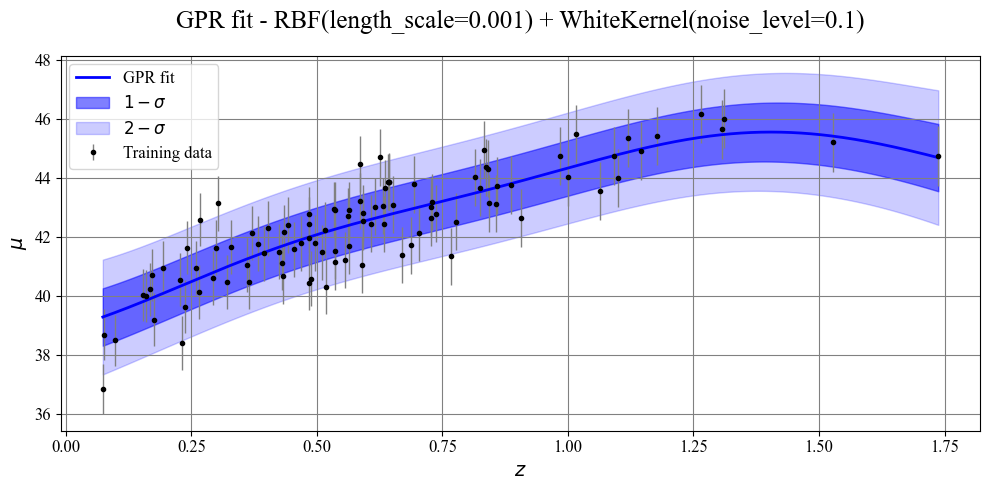

In [110]:
do_GPR_reg(grid.best_estimator_.kernel, scaler, X_scaled, plot_scaled_back=True)

In [111]:
Kernels.append(grid.best_estimator_.kernel)

In [112]:
# Define the regressor
gpr = GaussianProcessRegressor(kernel=Base_Kernels[1], n_restarts_optimizer=0)

# Define the param grid
param_grid = {
    'kernel__k1__length_scale': np.logspace(-3, -1, 10),
    'kernel__k1__nu': np.linspace(0.5, 2.5, 5),  
    'kernel__k2__noise_level': np.logspace(-1, 2, 5)
}


# Perform grid search
grid = GridSearchCV(gpr, param_grid, cv=custom_cv, scoring='neg_mean_squared_error')
grid.fit(x_train.reshape(-1, 1), y_train)

c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling f

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=GaussianProcessRegressor(kernel=Matern(length_scale=0.001, nu=1.5) + WhiteKernel(noise_level=1)),
             param_grid={'kernel__k1__length_scale': array([0.001     , 0.0016681 , 0.00278256, 0.00464159, 0.00774264,
       0.0129155 , 0.02154435, 0.03593814, 0.05994843, 0.1       ]),
                         'kernel__k1__nu': array([0.5, 1. , 1.5, 2. , 2.5]),
                         'kernel__k2__noise_level': array([  0.1       ,   0.56234133,   3.16227766,  17.7827941 ,
       100.        ])},
             scoring='neg_mean_squared_error')

In [113]:
Kernels.append(grid.best_estimator_.kernel)

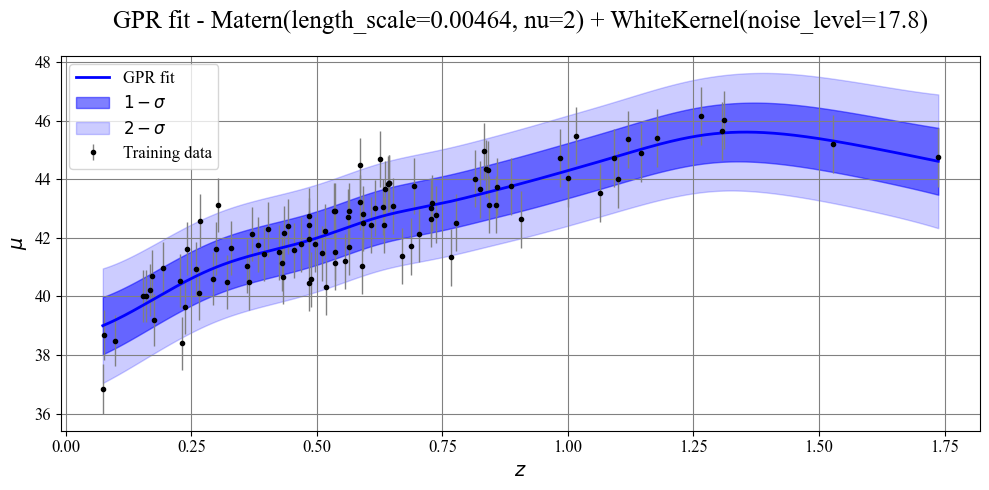

In [114]:
do_GPR_reg(grid.best_estimator_.kernel, scaler, X_scaled, plot_scaled_back=True)

In [115]:
# Define the regressor
gpr = GaussianProcessRegressor(kernel=Base_Kernels[2], n_restarts_optimizer=0)

# Define the param grid
param_grid = {
    'kernel__k1__alpha': np.linspace(1, 5, 10),
    'kernel__k1__length_scale': np.logspace(-3, -1, 10),
    'kernel__k2__noise_level': np.logspace(-1, 2, 5)
}

# Perform grid search
grid = GridSearchCV(gpr, param_grid, cv=custom_cv, scoring='neg_mean_squared_error')
grid.fit(x_train.reshape(-1, 1), y_train)

c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may fin

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=GaussianProcessRegressor(kernel=RationalQuadratic(alpha=1, length_scale=0.001) + WhiteKernel(noise_level=1)),
             param_grid={'kernel__k1__alpha': array([1.        , 1.44444444, 1.88888889, 2.33333333, 2.77777778,
       3.22222222, 3.66666667, 4.11111111, 4.55555556, 5.        ]),
                         'kernel__k1__length_scale': array([0.001     , 0.0016681 , 0.00278256, 0.00464159, 0.00774264,
       0.0129155 , 0.02154435, 0.03593814, 0.05994843, 0.1       ]),
                         'kernel__k2__noise_level': array([  0.1       ,   0.56234133,   3.16227766,  17.7827941 ,
       100.        ])},
             scoring='neg_mean_squared_error')

In [116]:
Kernels.append(grid.best_estimator_.kernel)

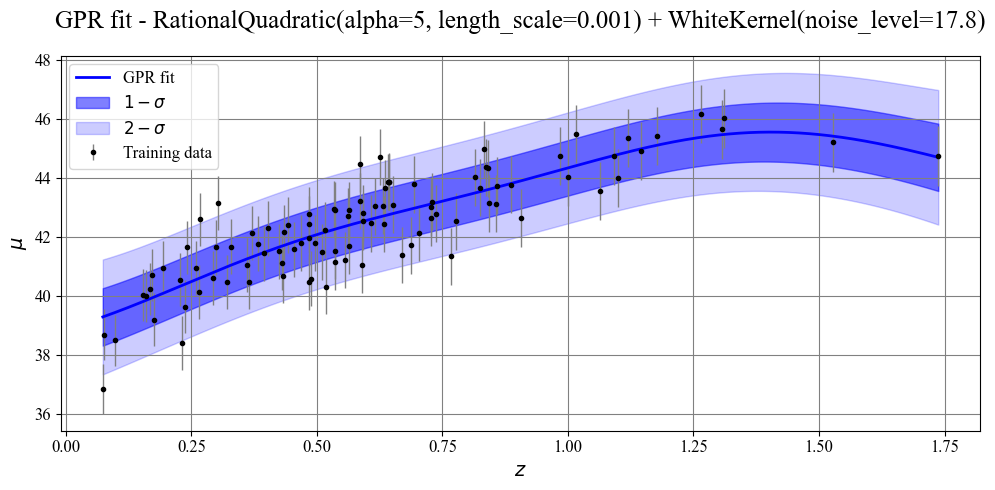

In [117]:
do_GPR_reg(grid.best_estimator_.kernel, scaler, X_scaled, plot_scaled_back=True)

In [118]:
best_kern, scores_dict = select_best_kernel(X_scaled.T[0], X_scaled.T[1], Kernels, custom_cv, n_restarts_optimizer=20)

Kernel: RBF(length_scale=0.001) + WhiteKernel(noise_level=0.1)
 Mean CV Score: -0.28502

Kernel: Matern(length_scale=0.00464, nu=2) + WhiteKernel(noise_level=17.8)
 Mean CV Score: -0.28062

Kernel: RationalQuadratic(alpha=5, length_scale=0.001) + WhiteKernel(noise_level=17.8)
 Mean CV Score: -0.28519

Best kernel selected: Matern(length_scale=0.00464, nu=2) + WhiteKernel(noise_level=17.8)
with CV score: -0.28062


In [119]:
best_kern

Matern(length_scale=0.00464, nu=2) + WhiteKernel(noise_level=17.8)

We have our kernel winner, Matern(length_scale=0.00464, nu=2) + WhiteKernel(noise_level=17.8).